# <font color='#2F4F4F'>AfterWork Data Science: Text Classification with Python - Project</font>

## <font color='#2F4F4F'>Step 1. Business Understading </font>

### a) Specifying the Research Question

Build a text classification model that classifies a given text input as written in english or in dutch.

### b) Defining the Metric for Success

Build a classification model with an accuracy of score of atleast 85%.

### c) Understanding the Context 

You work as a Computational Linguist for a Global firm, collaborating with Engineers and
Researchers in Assistant and Research & Machine Intelligence to develop language
understanding models that improve our ability to understand and generate natural
language.

### d) Recording the Experimental Design

* Business Understanding
* Data Exploration
* Data Preparation
* Data Modeling and Evaluation
* Summary of Findings 
* Recommendation
* Challenges


## <font color='#2F4F4F'>Step 2. Data Importation</font>

In [1]:
# Importing the required libraries
# ---
# 
import pandas as pd # library for data manipulation
import numpy as np  # librariy for scientific computations
import re           # regex library to perform text preprocessing
import string       # library to work with strings
import nltk         # library for natural language processing
import scipy        # scientific computing 
import seaborn as sns # library for data visualisation

# to display all columns
pd.set_option('display.max.columns', None)

# to display the entire contents of a cell
pd.set_option('display.max_colwidth', None)

# Library for Stop words
!pip3 install wordninja
!pip3 install textblob
import wordninja 
from textblob import TextBlob

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Library for Lemmatization
nltk.download('wordnet')
from textblob import Word

# Library for Noun count
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Library for TD-IDF
from sklearn.feature_extraction.text import TfidfVectorizer 

# Library for metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 541 kB 14.8 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=ebfa63a6d29773596334415357befc412082a3a61572372fe81c273bd643d9ef
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# Custom Functions
# ---
#

# Avg. words
def avg_word(sentence):
  words = sentence.split()
  try:
    z = (sum(len(word) for word in words)/len(words))
  except ZeroDivisionError:
    z = 0 
  return z

# Noun count
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

# Subjectivity 
def get_subjectivity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

# Polarity
def get_polarity(tweet):
    try:
        textblob = TextBlob(unicode(tweet, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [3]:
# loading and previewing the dataset
df = pd.read_csv('http://bit.ly/EnglishNDutchDs') 
df.sample(5)

,text,label
31,"Diogo called, the of (Cape the to Esperança, named first Rio probably Africa January of",en
68,"between Island, 1999. domestic reform, healthcare as He Pan on a split elder to",en
726,Men is het er niet over eens of dit schadelijk is of juist beter voor,nl
737,Marie Gabrielle Jozefa Aldegonda Adelheid Marghereta Ludovica Felicita Gennara van Savoye Napels februari is een,nl
462,"de Barcelona, de 6-1-overwinning in Messi september Kiev[66] van naar tegen Zlatan tegen",nl


## <font color='#2F4F4F'>Step 3. Data Exploration</font>

In [4]:
# check dataset shape
df.shape

(1069, 2)

Our dataset has 1069 records and 2 variables.

In [5]:
# preview variable datatypes
df.dtypes

text     object
label    object
dtype: object

Both variables have the data type object. This is fine for the text variable, however for the label, we will need to convert it to a numerical format. We will do this later.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


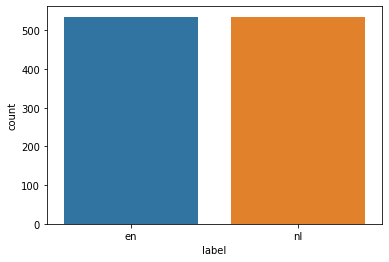

In [6]:
# plotting the distribution of label
# ---
#
sns.countplot(df['label']);

In [7]:
# investigating the label distribution
df['label'].value_counts()

nl    535
en    534
Name: label, dtype: int64

From above, we can see that our dataset is unbalanced thus we will need to sample equal no. of records for each label during data preparation to make a balanced dataset.

## <font color='#2F4F4F'>Step 4. Data Preparation</font>

### <font color='#2F4F4F'>3.1 Data Cleaning</font>

In [8]:
# check for duplicates
df.duplicated().sum()

10

There are 10 duplicates. We will need to drop these.

In [9]:
# check for missing values
df.isna().sum()

text     0
label    0
dtype: int64

No missing values found. 

In [10]:
# dropping our duplicates
df = df.drop_duplicates()
df.shape

(1059, 2)

In [11]:
# What values are in our label variable?
# ---
#
df.label.unique()

array(['en', 'nl'], dtype=object)

In [12]:
# sampling text with en 
df_en = df[df["label"] == 'en'] 
df_en = df_en.sample(200)

# sampling text with nl 
df_nl = df[df["label"] == 'nl'] 
df_nl = df_nl.sample(200)

# combining our dataframes
df = pd.concat([df_en, df_nl])
df.head()

,text,label
919,However the Soviet Union and later Russia constructed a number of manned drifting stations on,en
80,"of House Wesley year, BA he when Jongintaba's had food, challenged an part in D.",en
552,collection of ambient works. The album was recorded primarily at his home studio with the,en
1027,The core of Arzawa is believed to be along the Kaystros River now known as,en
145,his created war went Lambert English a presided and in no civil 1660. was then,en


In [13]:
# investigating the label distribution
df['label'].value_counts()

en    200
nl    200
Name: label, dtype: int64

In [30]:
df_tst=df.copy()

We now have our balanced dataset. 

### <font color='#2F4F4F'> 3.2 Text Cleaning</font>

In [39]:
# We will create a custom function that will contain all the text cleaning 
# techniques. We can then reuse the same function for cleaning new data
# without rewriting the code.
# ---
# 
def clean_text (text):
  # Removing all urls/links
  cln_txt = re.sub(r'http\S+|www\S+|https\S+','', str(text))

  # Removing @ and # characters or replace them with space
  cln_txt = cln_txt.replace('@',' ').replace('#',' ')

  # Convert to lower case
  cln_txt = cln_txt.lower()

  return cln_txt

In [41]:
df_tst.head()

,text,label
919,however the soviet union and later russia constructed a number of manned drifting stations on,en
80,"of house wesley year, ba he when jongintaba's had food, challenged an part in d.",en
552,collection of ambient works. the album was recorded primarily at his home studio with the,en
1027,the core of arzawa is believed to be along the kaystros river now known as,en
145,his created war went lambert english a presided and in no civil 1660. was then,en


In [42]:
# Applying the text_cleaning function to our dataframe.
# ---
# NB: This process may take 5-10 min.
# ---
#
df["text"] = df["text"].apply(clean_text)

### <font color='#2F4F4F'> 3.3 Feature Engineering</font>

In [44]:
# We will create a custom function that will contain all the 
# feature engineering techniques. We can then use this function 
# for cleaning new data. 
# ---
#
# Spliting
df['split_text']=df['text'].str.split()
df.head()
df.drop(columns=['split_text'],inplace=True)

# remove punctuations
df['text'] = df['text'].str.replace('[^\w\s]','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':


In [45]:
# Remove stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['no_of_stopwords'] = df.text.apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','no_of_stopwords']].sample(10)

,text,no_of_stopwords
194,currents in the the world interactions used higher conductivity elements wartime single in the carbon,5
258,de amerikaanse stad san francisco wordt getroffen door een aardbeving met een kracht van naar,0
688,monstrilla fosshageni is een eenoogkreeftjessoort uit de familie van de monstrillidae de wetenschappelijke naam van,1
1026,arzawa was the name of a region and a political entity a kingdom or a,9
889,owned by dr kamal ahuja and founded in the centre has a reputation for helping,7
689,de soort is voor het eerst geldig gepubliceerd in 2001 door suarez morales dias,2
852,het directoraatgeneraal floreerde onder het voorzitterschap van eurocommissaris neelie kroes en haar beleid is voortgezet,1
981,keating was one of many moderate to liberal republicans who refused to endorse conservative republican,5
868,competing in three winter olympics he earned frances first ever winter olympic crosscountry skiing medal,2
972,according to beardsley it was a big deal for both of us because neither one,8


In [47]:
# Lematization
nltk.download('omw-1.4')
df['lemmatization'] = df.text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 
df[['text', 'lemmatization']].sample(10)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,text,lemmatization
897,he was also cast as one of the talents on the teen musical variety show,he wa also cast a one of the talent on the teen musical variety show
497,meisje wijze johansson de haar een award voor in the een opgemerkt horse voor,meisje wijze johansson de haar een award voor in the een opgemerkt horse voor
1020,the band released reverberation to mostly negative reviews though the album has subsequently garnered some,the band released reverberation to mostly negative review though the album ha subsequently garnered some
121,flourished under the the came english been 1100 nearly became own to the grown,flourished under the the came english been 1100 nearly became own to the grown
515,kritiseert hij onder meer de opvatting uit de strafrechtpraktijk dat in juridische stukken zoals een,kritiseert hij onder meer de opvatting uit de strafrechtpraktijk dat in juridische stukken zoals een
637,naar aanleiding van de belgische revolutie begon hij zich aan politiek te interesseren hij werd redacteur,naar aanleiding van de belgische revolutie begon hij zich aan politiek te interesseren hij werd redacteur
310,orkut derden een was dergelijke een meer gaan schaken kwam ook nederlandse andere concurrenten poker,orkut derden een wa dergelijke een meer gaan schaken kwam ook nederlandse andere concurrenten poker
52,back 35th partys would that ifp buthelezi in elections the of 2019 velenkosini kwazulunatal33 intention,back 35th party would that ifp buthelezi in election the of 2019 velenkosini kwazulunatal33 intention
615,eerder uitgebarsten vulkaan uit hetjaar geleden gevormd boven op een,eerder uitgebarsten vulkaan uit hetjaar geleden gevormd boven op een
600,de wetenschappelijke naam van de soort is voor het eerst geldig gepubliceerd in 1888 door moore,de wetenschappelijke naam van de soort is voor het eerst geldig gepubliceerd in 1888 door moore


In [51]:
# Applying the custom feature engineering function to our dataframe.
# This process may take 2-5 min.
# ---
#
pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

def pos_check(x, flag):
    cnt = 0
    try:
        wiki = TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_dic[flag]:
                cnt += 1
    except:
        pass
    return cnt

def get_polarity(text):
    try:
        textblob = TextBlob(unicode(text, 'utf-8'))
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

def get_subjectivity(text):
    try:
        textblob = TextBlob(unicode(text, 'utf-8'))
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

def feature_engineering(text):
  # Length of text
  df['length_of_text'] = df.text.str.len()

  # Word count 
  df['word_count'] = df.text.apply(lambda x: len(str(x).split(" ")))

  # Word density (Average no. of words / text)
  df['avg_word_length'] = df.text.apply(lambda x: avg_word(x)) 
  
  # Noun Count
  df['noun_count'] = df.text.apply(lambda x: pos_check(x, 'noun'))

  # Verb Count
  df['verb_count'] = df.text.apply(lambda x: pos_check(x, 'verb'))

  # Adjective Count / text
  df['adj_count'] = df.text.apply(lambda x: pos_check(x, 'adj'))

  # Adverb Count / text
  df['adv_count'] = df.text.apply(lambda x: pos_check(x, 'adv'))

  # Pronoun 
  df['pron_count'] = df.text.apply(lambda x: pos_check(x, 'pron'))

  # Subjectivity 
  df['subjectivity'] = df.text.apply(get_subjectivity)

  # Polarity
  df['polarity'] = df.text.apply(get_polarity)        

In [52]:
# Appling feature engineering
df.text.apply(feature_engineering)
df.sample(5)

,text,label,no_of_stopwords,lemmatization,length_of_text,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,pron_count,subjectivity,polarity
624,deel uit van het turks voetbalelftal waarmee hij in 2002 aan de wereldbeker deelnam aşık,nl,1,deel uit van het turk voetbalelftal waarmee hij in 2002 aan de wereldbeker deelnam aşık,88,15,4.933333,10,0,2,0,0,0.0,0.0
140,part church under english english the trial ended consolidated outcome the briefly in worship of,en,5,part church under english english the trial ended consolidated outcome the briefly in worship of,96,15,5.466667,5,2,2,0,0,0.0,0.0
595,van de film verscheen een soundtrackalbum met songs van johnny cash met carl perkins en,nl,0,van de film verscheen een soundtrackalbum met song van johnny cash met carl perkins en,87,15,4.866667,7,2,3,0,0,0.0,0.0
857,in gygaxs own campaign an early version of dungeonland was an extension of castle greyhawk,en,7,in gygaxs own campaign an early version of dungeonland wa an extension of castle greyhawk,90,15,5.066667,6,1,3,0,0,0.0,0.0
983,he served in india until when he resigned and returned home to campaign for the,en,9,he served in india until when he resigned and returned home to campaign for the,79,15,4.333333,3,3,0,1,2,0.0,0.0


In [53]:
# Performing further feature engineering techniques
# ---
#

from nltk import word_tokenize, ngrams
list(ngrams(word_tokenize(df['text'][0]), 2)) 

# Feature Construction: Word Level N-Gram TF-IDF Feature 
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', ngram_range=(1,3),  stop_words= 'english')
df_word_vect = tfidf.fit_transform(df.text) 


# Feature Construction: Character Level N-Gram TF-IDF 
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char', ngram_range=(1,3),  stop_words= 'english')
df_char_vect = tfidf.fit_transform(df.text)



In [58]:
df.head()

,text,label,no_of_stopwords,lemmatization,length_of_text,word_count,avg_word_length,noun_count,verb_count,adj_count,adv_count,pron_count,subjectivity,polarity
919,however the soviet union and later russia constructed a number of manned drifting stations on,en,5,however the soviet union and later russia constructed a number of manned drifting station on,93,15,5.266667,3,3,2,2,0,0.0,0.0
80,of house wesley year ba he when jongintabas had food challenged an part in d,en,7,of house wesley year ba he when jongintabas had food challenged an part in d,76,15,4.133333,7,2,1,1,1,0.0,0.0
552,collection of ambient works the album was recorded primarily at his home studio with the,en,7,collection of ambient work the album wa recorded primarily at his home studio with the,88,15,4.933333,5,3,0,1,1,0.0,0.0
1027,the core of arzawa is believed to be along the kaystros river now known as,en,8,the core of arzawa is believed to be along the kaystros river now known a,74,15,4.000000,3,4,0,2,0,0.0,0.0
145,his created war went lambert english a presided and in no civil 1660 was then,en,7,his created war went lambert english a presided and in no civil 1660 wa then,77,15,4.200000,1,4,3,1,1,0.0,0.0


In [59]:
# Let's prepare the constructed features for modeling
# ---
# We will select all variables but the target (which is the label) and text variables 
# ---
#  
X = np.array(df.drop(columns = ['text','label','lemmatization']))
y = np.array(df['label'])

In [61]:
# We combine our two tfidf (sparse) matrices and X_metadata
# ---
#
X = scipy.sparse.hstack([df_word_vect, df_char_vect
                        #  ,  X_metadata
                         ])
X

<400x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 56859 stored elements in COOrdinate format>

In [62]:
# Label Preparation i.e. replacing categorial values with numerical ones
# ---  
#
y = np.array(df['label'].replace(['en', 'nl'], ['1','0']))

##  <font color='#2F4F4F'>Step 5. Data Modeling</font>

We will carry out 10 types of classification analysis, namely:
1.  Logistic Regression
3.  Decision Trees Classification
4.  Support Vector Machine (SVM) Classification
5. K-Nearest Neighbors (KNN) Classification
6.  Gaussian Naive Bayes (NB) Classification
7.  BaggingClassifier
8.  RandomForestClassifier
9.  AdaBoostClassifier
10. GradientBoostingClassifier

We use their default parameters then compare the different classification models to assess the best performing one(s). 

In [63]:
# splitting into 80-20 train-test sets
# ---
#
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [66]:
# loading our classification libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# instantiating our classifiers
logistic_classifier = LogisticRegression()
naive_classifier = GaussianNB()
decision_classifier = DecisionTreeClassifier()
knn_classifier = KNeighborsClassifier()
svm_classifier = SVC()

# fitting our classifiers to the training data
logistic_classifier.fit(X_train, y_train)
decision_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
knn_classifier.fit(X_train, y_train)

# making predictions
logistic_prediction = logistic_classifier.predict(X_test)
decision_prediction = decision_classifier.predict(X_test)
svm_prediction = svm_classifier.predict(X_test)
knn_prediction = knn_classifier.predict(X_test)

In [67]:
# Evaluating the Models
# ---

# Accuracy scores
#
# printing the classification report for each classifier to assess performance
from sklearn.metrics import classification_report, accuracy_score

# classification report for Logistic Regression
print(accuracy_score(logistic_prediction, y_test))

# classification report for Decision Tree Classifier
print(accuracy_score(decision_prediction, y_test))

# classification report for K-Nearest Neighbors Classifier
print(accuracy_score(knn_prediction, y_test))

# classification report for Support Vector Machine Classifier
print(accuracy_score(svm_prediction, y_test))

1.0
0.9125
0.6375
1.0


Your observation about the performance of the models...

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


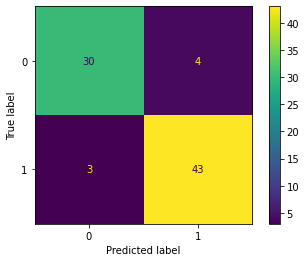

In [69]:
# Confusion matrices
# ---
# Decision Tree Classifier
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(decision_classifier, X_test, y_test)  
plt.show()



In [70]:
# Classification Reports
# ---
# 

## <font color='#2F4F4F'>Step 6. Summary of Findings and Recommendation</font>

## <font color='#2F4F4F'>Step 7. Challenging our Solution</font>